# Urban Activity Topics 

This notebook is about a study on geospatial topic modeling to extract 'urban activity topics' from fine-grained hourly population estimate data using non-negative matrix factorization. 

Early in 2018, the City of Seoul started to publish a dataset collecting hourly estimated population for each census tract (total 19,153) in Seoul everyday. The City of Seoul created this detailed synthetic dataset combining the population census data and real-time cell phone location data in collaboration with a major cell phone carrier company of South Korea. 

We identified urban activity topics by applying non-negative matrix factorization (NMF) to the location-time matrix whose row is each census tract(19,153) and column is each hourly timeslot(7X24), and elements are the average number of estimated population in the census tract at the timeslot. NMF on the location-time matrix yields two matrices. One matrix describes how each timeslot contributes to activity topics. The other matrix describes how each census tract is composed of the activity topics.

We were able to identify well-clustered activity topics repetitively found across census tracts such as weekday daytime, night-to-morning, weekend afternoons, evening times, commuting times and so on. Also, the method reveals how urban places are composed of the topics we found and how the topics are geographically located.

See the notebook below and [the web application](https://s3.amazonaws.com/seoul-topics/www/index.html) for the details.


In [5]:
import os
import glob
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import altair as alt
from altair.expr import datum


## Hourly population data

City of Seoul publishes dataset for estimated hourly population for each census tract (total 19153) collaborating with a major cell phone carrier company. We converted the csv files
from the City of Seoul into parquet files and uploaded into S3 so that we can utilize
aws athena to aggregate average hourly population over 21 months.

See this notebook for converting:
https://github.com/yonghah/urban-activity-topics/blob/master/notebooks/UrbanActivityTopicsNMF.ipynb

See this notebook for data aggregation using AWS Athena:
https://github.com/yonghah/urban-activity-topics/blob/master/notebooks/DataAggregateInAthena.ipynb



In [11]:
filename = "../data/interim/aggregate_wide.csv"
df = pd.read_csv(filename, index_col='census_id')
df.head()

,D1T00,D1T01,D1T02,D1T03,D1T04,D1T05,D1T06,D1T07,D1T08,D1T09,...,D7T14,D7T15,D7T16,D7T17,D7T18,D7T19,D7T20,D7T21,D7T22,D7T23
census_id,,,,,,,,,,,,,,,,,,,,,
1101053010001,397.934066,391.835165,390.043956,387.483516,360.747253,354.384615,358.450549,341.043956,315.505495,302.780220,...,364.304348,383.369565,364.467391,371.532609,376.163043,369.369565,364.456522,339.130435,331.652174,388.826087
1101053010002,1180.208791,1179.494505,1164.747253,1154.934066,1166.978022,1213.472527,1314.571429,1508.901099,1650.439560,1723.912088,...,1751.717391,1737.141304,1707.728261,1745.717391,1815.956522,1799.532609,1780.184783,1655.880435,1502.130435,1200.336957
1101053010003,1258.043956,1261.208791,1249.626374,1249.593407,1271.824176,1288.703297,1302.637363,1535.791209,1573.351648,1590.483516,...,1979.434783,1982.836957,2021.956522,1999.293478,1894.586957,1690.717391,1452.326087,1377.336957,1331.173913,1281.760870
1101053010004,1222.637363,1139.109890,1152.857143,1135.670330,1161.549451,1248.065934,1479.461538,2218.461538,3026.835165,3513.923077,...,3326.510870,3395.684783,3420.282609,3273.489130,2984.793478,2663.326087,2379.967391,2168.771739,1945.706522,1325.043478
1101053010005,833.373626,827.703297,793.373626,794.714286,791.681319,865.780220,1072.527473,1527.197802,2511.065934,2848.054945,...,2487.119565,2474.152174,2333.043478,2088.760870,1890.358696,1847.782609,1729.750000,1573.869565,1433.891304,873.423913


## Run NMF

### Find the best topic number

In [15]:
def get_rss(no_topics):
    nmf = NMF(n_components=no_topics, random_state=1, alpha=.2, l1_ratio=0, init='nndsvd').fit(X)
    basis = nmf.fit_transform(X) 
    coef = nmf.components_  
    rss = np.sum(np.square(X - np.matmul(basis, coef)))
    return rss

In [16]:
topic_numbers = list(range(5, 25))
rss_scores = list(map(get_rss, topic_numbers))

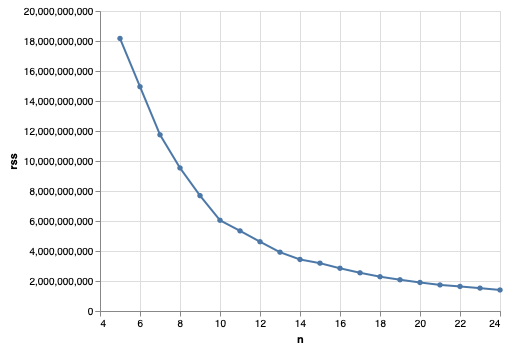

In [17]:
alt.Chart(pd.DataFrame({'n':topic_numbers, 'rss':rss_scores}))\
.mark_line(point=True)\
.encode(
    x='n:Q',
    y='rss:Q',
)

### Run with N=15

In [19]:
no_topics = 15
X = df.values
feature_names = list(df.columns)
print(X.shape)

nmf = NMF(n_components=no_topics, random_state=1, alpha=.2, l1_ratio=0, init='nndsvd').fit(X)

# W
basis = nmf.fit_transform(X) 
print(basis.shape)

# H
coef = nmf.components_  
print(coef.shape)

(19153, 168)
(19153, 15)
(15, 168)


## Visualize topics

In [20]:
records = []
for topic_idx, topic in enumerate(coef):
    for feature_idx, score in enumerate(topic):
        feature_name = feature_names[feature_idx]
        day = int(feature_name[1:2])
        hour = int(feature_name[3:5])
        record = {'topic': 'topic_{:02d}'.format(topic_idx), 
                  'day':day, 
                  'hour':hour, 
                  'score':round(score,2)}
        records.append(record)
df_topic = pd.DataFrame.from_records(records)
df_topic.head()

,day,hour,score,topic
0,1,0,0.0,topic_00
1,1,1,0.0,topic_00
2,1,2,0.0,topic_00
3,1,3,0.0,topic_00
4,1,4,0.0,topic_00


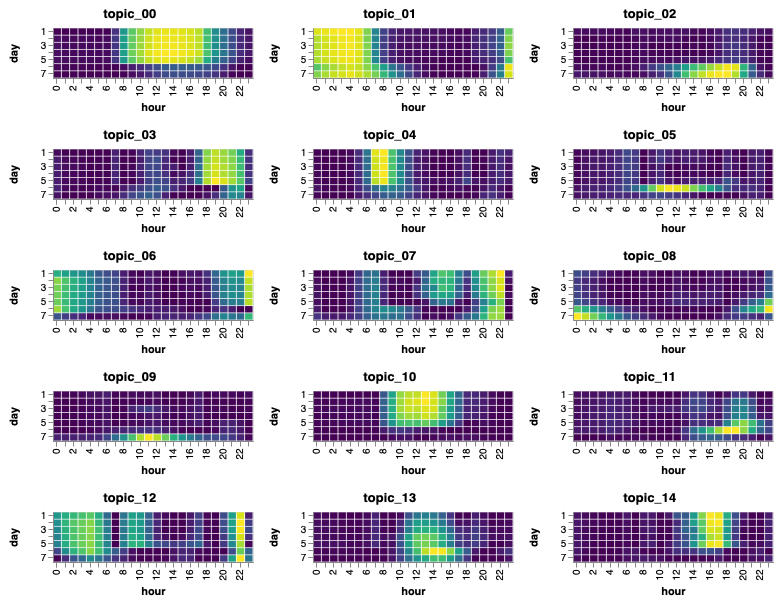

In [21]:
numcols = 3 

all_topics = df_topic['topic'].unique() 
rows = alt.vconcat(data=df_topic)
numrows = int(np.ceil(len(all_topics) / numcols))
pointer = 0

for _ in range(numrows):
    row = all_topics[pointer:pointer+numcols]
    cols = alt.hconcat()

    for a_chart in row:
        chart = alt.Chart(df_topic)\
        .mark_rect()\
        .encode(
            alt.X('hour:O', axis=alt.Axis(title='hour')),
            alt.Y('day:O', axis=alt.Axis(title='day')),
            color=alt.Color('score:Q', legend=None)
        )\
        .transform_filter(datum.topic == a_chart)\
        .properties(width=200, height=50, title=a_chart)
        cols |= chart

    rows &= cols.resolve_scale(color='independent', x='independent')
    pointer += numcols

rows

## Mapping Topics

We'd like to see where these topics are located in Seoul. So we are going to make a choropleth map with these topics. 

You can download Polygons for Seoul's census tracts from here:

https://data.seoul.go.kr/together/statbook/fileDownload.do?cotCd=999&filename=%ED%86%B5%EA%B3%84%EC%A7%80%EC%97%AD%EA%B2%BD%EA%B3%84(2016%EB%85%84%20%EA%B8%B0%EC%A4%80).zip

Unzip the zipped shapefile in the raw data folder.
Its columns are:

* census tract ID
* neighborhood name
* neighborhood code
* geometry

In [22]:
map_census = gpd.read_file("../data/raw/geo/census.shp")
map_census.crs = "+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs"
map_census.head()

,TOT_REG_CD,ADM_NM,ADM_CD,geometry
0,1101053010006,»çÁ÷µ¿,1101053,"POLYGON ((953231.9682865143 1953435.865716934,..."
1,1101053010001,»çÁ÷µ¿,1101053,"POLYGON ((952858.5655841827 1952976.274114609,..."
2,1101053010003,»çÁ÷µ¿,1101053,"POLYGON ((952889.1776866913 1953405.245515823,..."
3,1101053010002,»çÁ÷µ¿,1101053,"POLYGON ((953093.8012866974 1953337.962316513,..."
4,1101053010005,»çÁ÷µ¿,1101053,"POLYGON ((953553.9324855804 1953335.741514206,..."


Convert basis matrix to dataframe so that each census has columns for topic coefficients.

In [27]:
# row-wise normalization 
df_census = pd.DataFrame(
    normalize(basis, norm='l2', axis=1)
)

#df_census = pd.DataFrame(basis)
df_census.columns = ["topic_{}".format(i) for i in list(df_census.columns)]
df_census['census'] = list(df.index)
df_census['census'] = df_census['census'].apply(str)
df_census.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,census
0,0.237629,0.734397,0.343441,0.164444,0.197365,0.047619,0.350740,0.043112,0.153013,0.146500,0.216399,0.000000,0.028336,0.024386,0.000000,1101053010001
1,0.445474,0.515243,0.344275,0.362649,0.234729,0.074169,0.248232,0.074727,0.141601,0.164054,0.317546,0.080254,0.031890,0.054565,0.000000,1101053010002
2,0.529781,0.616729,0.395508,0.113407,0.214431,0.053746,0.210707,0.101791,0.129951,0.139760,0.053104,0.076214,0.053238,0.134495,0.009420,1101053010003
3,0.679444,0.181908,0.324298,0.350275,0.212027,0.063300,0.146296,0.024296,0.162155,0.080735,0.000000,0.122950,0.078923,0.159863,0.355998,1101053010004
4,0.831519,0.123662,0.147911,0.129102,0.165202,0.060219,0.227892,0.115927,0.140880,0.170496,0.000000,0.208174,0.055841,0.199417,0.152674,1101053010005


Join the two dataframe into one. 

In [28]:
df_map = pd.merge(map_census, df_census, right_on='census', left_on='TOT_REG_CD')
df_map.drop(columns=['TOT_REG_CD', 'ADM_CD'], inplace=True)

### plots

Topic 0 is for weekday daytime activities. We can see the central business districts such as Jongro, Yeouido, and Teheran street. For more topics, use the web application.

https://s3.amazonaws.com/seoul-topics/www/index.html

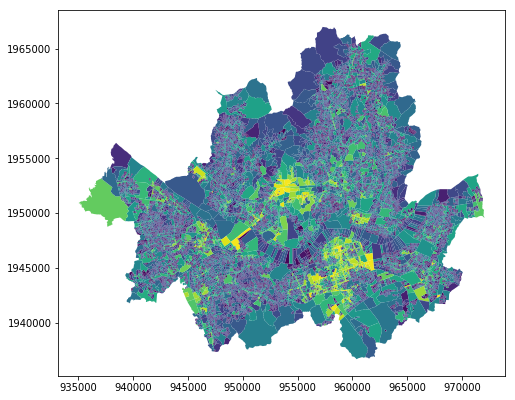

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline 
df_map.plot(column='topic_0', figsize=(8,8))

Topic 8 is for weekend nights. Nightlife streets such as Itaewon, Hongdae, Gangnam are hihglighted.

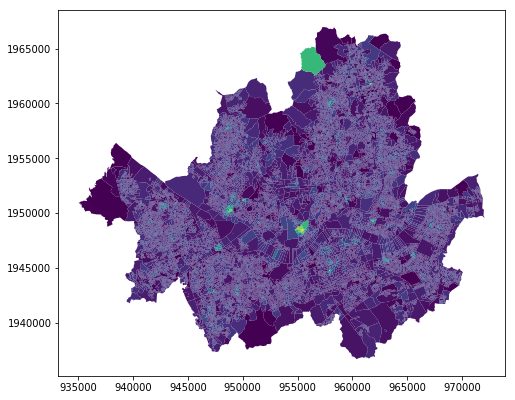

In [33]:
df_map.plot(column='topic_8', figsize=(8,8))

## Generate datasets for web mapping application


### Geojson

In [34]:
# chagne crs to epsg:4326
df_map_wgs = df_map.to_crs({'init': 'epsg:4326'})

# export geopandas dataframe to geojson
geojson = "../data/processed/census-topic.geojson"
if os.path.exists(geojson):
    os.remove(geojson)
df_map_wgs.to_file(geojson, driver="GeoJSON")

/Users/yonghah/anaconda3/envs/ped-topic/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /Users/yonghah/repo/ped-topic/data/processed/census-topic.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /Users/yonghah/repo/ped-topic/data/processed/census-topic.geojson does not support layer creation option ENCODING


### Generate vector tiles from the geojson file

- Create mbtiles using [tippecanoe](https://github.com/mapbox/tippecanoe) and 
- unzip tiles with [mb-util](https://github.com/mapbox/mbutil). 
- Then upload the tiles to S3 using AWS CLI.

```
cd ../data/processed
tippecanoe -o census-topic.mbtiles -Z9 -z14 -S12 -ab -pk -pC  census-topic.geojson -f
rm -rf tile
mb-util census-topic.mbtiles tile --image_format=pbf
aws s3 sync tile s3://seoul-topics/tile
```

### max value table for web app

In [35]:
df_map_wgs.drop(columns='ADM_NM').max(axis=0).to_json()

'{"topic_0":0.9617289532,"topic_1":0.9936660192,"topic_2":0.9582582954,"topic_3":0.9244264603,"topic_4":0.7634331003,"topic_5":0.3669040362,"topic_6":0.882861761,"topic_7":0.366777168,"topic_8":0.9454749465,"topic_9":0.7852910221,"topic_10":0.8959908057,"topic_11":0.7249125909,"topic_12":0.4262215718,"topic_13":0.6373642553,"topic_14":0.9449404126}'

### topics for the sidebar 

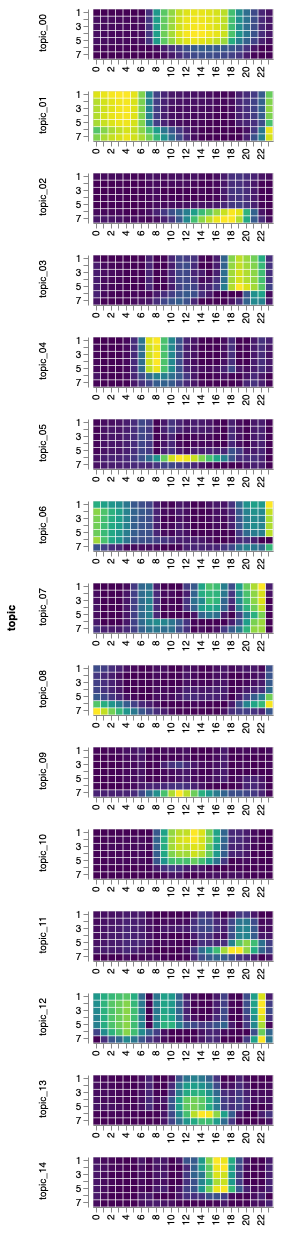

In [38]:
alt.Chart(df_topic)\
.mark_rect()\
.encode(
    alt.X('hour:O', axis=alt.Axis(title='')),
    alt.Y('day:O', axis=alt.Axis(title='')),
    color=alt.Color('score:Q', legend=None)
)\
.properties(width=180, height=50)\
.facet(row='topic:N')\
.resolve_scale(color='independent', x='independent')

### Web Application
https://s3.amazonaws.com/seoul-topics/www/index.html